In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import umap

import matplotlib.pyplot as plt
import matplotlib
 
import pickle as pk
import h5py

# Load data

Our algorithm requires at least two inputs:

- `count`$\in \mathbb{R}^{n_{\text{cell}}\ \ \times\ \ n_{\text{gene}}}$, the raw count matrix for the UMI/non-UMI model, or the preprocessed expression matrix for the Gaussian model.
- `NUM_CLUSTER`$\in \mathbb{N}^+$, the number of clusters.

One can also provides some prior information:

- `grouping`$\in \mathbb{R}^{n_{\text{cell}}}$, the true/estimated groupings
- `gene_names`$\in \mathbb{R}^{n_{\text{cell}}}$
- `cell_ids`$\in \mathbb{R}^{n_{\text{cell}}}$

We have prepare some datasets in **hdf5** format, which can be easily loaded by the following codes:

In [3]:
from scTGMVAE import get_igraph, louvain_igraph, plot_clusters, load_data

file_name = 'dentate'
data = load_data(path='data/',
                 file_name=file_name)

# To see the available fields of the dataset
print(data.keys())

dict_keys(['count', 'grouping', 'gene_names', 'cell_ids', 'milestone_network', 'root_milestone_id', 'type'])


# Preprocess data

We follows the precedure

- Remove cells without expressions.
- Remove genes without variations across samples.
- Apply log-normalization to the count data $X$ and get $X_{\text{norm}}$.
- Select influential genes based on $X$ by the method described in Page 12-13: Data preprocessing - Feature selection for individual datasets, https://www.biorxiv.org/content/biorxiv/early/2018/11/02/460147.full.pdf.
- Apply per-gene standardization to $X_{\text{norm}}$ as the input of the neural network.


min normailized value: 0.0
max normailized value: 8.149757


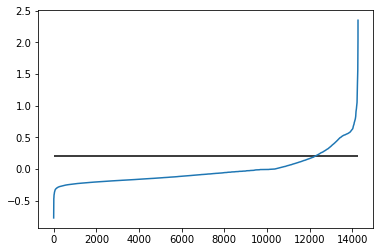

Number of cells in each class: 
0 <---> Granule-immature    1333
1 <---> Granule-mature      1712
2 <---> Neuroblast_1          97
3 <---> Neuroblast_2         777
4 <---> nIPC                  88
dtype: int64


In [4]:
from scTGMVAE import scTGMVAE

# clear the tf session if necessary
tf.keras.backend.clear_session() 

# create an instance
model = scTGMVAE()

# fit in data
model.get_data(data['count'],                 # count or expression matrix, (dense or sparse) numpy array 
               data['grouping'],              # (optional) labels, which will be converted to string
               covariate=None,                # (optional) covariates
               gene_names=data['gene_names'], # (optional) gene names, which will be converted to string
               cell_names=None                # (optional) cell names, which will be converted to string
              )

# preprocess data
model.preprocess_data(K = 1e4,                # (optional) denominator of the scale factor for log-normalization (the default is 1e4)
                      gene_num = 2000,        # (optional) maximum number of influential genes to keep (the default is 2000)
                      data_type = 'UMI',      # (optional) data_type can be 'UMI', 'non-UMI' or 'Gaussian' (the default is 'UMI')
                      npc = 64                # (optional) number of PCs to keep if data_type='Gaussian' (the default is 64)
                     )

# Build model

Now we are able to create the neural network.

In [5]:
model.build_model(dim_latent = 8,         # The size of the latent dimension
                  dimensions=[16]         # The size of each layer in the encoder between the input layer and the 
                                          # latent layer. The size of each layer in the decoder is the reverse.
                  )

# Pretrain

In the current stage, we only define the Autoencoder. The latent sturcture is still undefined. Before adding that, we'd better pretrain the Autoencoder to learn a better reprsentation $Z$ of $X$.

A large batch size will give a better and stable model, while it takes more memory to run. So if you are concerned about this, you could reduce the batch size.

In [6]:
model.pre_train(learning_rate = 1e-3,        # (Optional) the initial learning rate for the Adam optimizer (the default is 1e-3).
                batch_size=256,              # (Optional) the batch size for pre-training (the default is 32). 
                L=1,                         # (Optional) the number of MC samples (the default is 1).
                num_epoch = 300,             # (Optional) the maximum number of epoches (the default is 300).                
                num_step_per_epoch = None,   # (Optional) the number of step per epoch, it will be inferred from number of cells and batch size if it is None (the default is None).
                early_stopping_tolerance=1,  # (Optional) the minimum change of loss to be considered as an improvement (the default is 1e-3).
                early_stopping_patience=5,   # (Optional) the maximum number of epoches if there is no improvement (the default is 10).
                early_stopping_warmup=0,     # (Optional) the number of warmup epoches (the default is 0).
                path_to_weights=None         # (Optional) the path of weight file to be saved; not saving weight if None (the default is None).
                ) 

Pretrain - Start of epoch 0
16/16 [==============================] - 3s 200ms/step - Reconstructed Loss: 1246.3208
 Training loss over epoch: 1248.61376953125
Pretrain - Start of epoch 1
16/16 [==============================] - 3s 179ms/step - Reconstructed Loss: 1216.2599
 Training loss over epoch: 1216.8646240234375
Pretrain - Start of epoch 2
16/16 [==============================] - 3s 179ms/step - Reconstructed Loss: 1168.3146
 Training loss over epoch: 1172.855224609375
Pretrain - Start of epoch 3
16/16 [==============================] - 3s 178ms/step - Reconstructed Loss: 1137.9155
 Training loss over epoch: 1138.4837646484375
Pretrain - Start of epoch 4
16/16 [==============================] - 3s 178ms/step - Reconstructed Loss: 1118.5536
 Training loss over epoch: 1111.2459716796875
Pretrain - Start of epoch 5
16/16 [==============================] - 3s 178ms/step - Reconstructed Loss: 1107.8794
 Training loss over epoch: 1095.3369140625
Pretrain - Start of epoch 6
16/16 [=====

You can also save and load model weights by the following codes:

In [ ]:
# save model weight
model.save_model(path_to_file='model.checkpoint')

# load model weight
model.load_model(path_to_file='pre_train.checkpoint', # path to the weight file.
                 n_clusters=None                      # (Optional) parameter to initialize or re-initialize the GMM layer
                                                      # set to None if we don't know the number of clusters yet.
                )

# Clustering and initialize latent structure

If you have information of the grouping/labels of cells, you are free to use them to initialze the latent structure, so that you will get better estimate and inference results, especially when the sample size is small or the classes are unbalanced.

In [7]:
# Get latent representations of X after pre-training
z = model.get_latent_z()

# Assign pre-given labels to initialize the latent structure
# The object 'model.labels' is encoded as categorical data from 'model.label_names'.
labels = model.labels    

We can plot the clusters to see how it looks like.

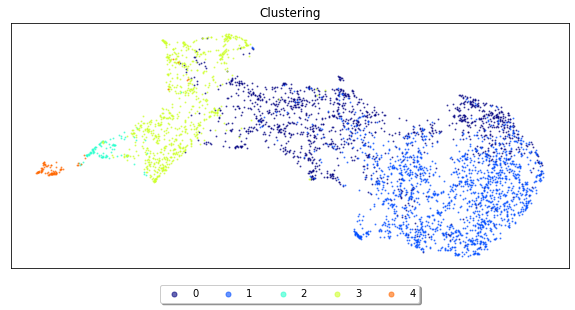

In [8]:
# Dimension reducation via UMAP
embed_z = umap.UMAP().fit_transform(z)        
plot_clusters(embed_z, labels)

Now we are able to determine $k$, and initialze $\pi$ and $\mu$.

In [9]:
NUM_CLUSTER = len(np.unique(labels))
n_states = int((NUM_CLUSTER+1)*NUM_CLUSTER/2)
cluster_center = [int((NUM_CLUSTER+(1-i)/2)*i) for i in range(NUM_CLUSTER)]
mu = np.zeros((z.shape[1],NUM_CLUSTER))
log_pi = np.ones((1,n_states)) * (-16)
for i,l in enumerate(np.unique(labels)):
    mu[:,i] = np.mean(z[labels==l], axis=0)
    log_pi[0, cluster_center[i]] = np.log(np.mean(labels==l))

model.init_GMM(NUM_CLUSTER,                     # numebr of clusters
               cluster_labels=labels,           # (optional) clustering labels or their names for plotting
               mu=mu,                           # (optional) initial mean
               log_pi=log_pi                    # (optional) initial pi
               )                   

In case we don't have labels, we could do Louvain clustering by the following codes.

```
from scTGMVAE import get_igraph, louvain_igraph, plot_clusters
z = model.get_latent_z()
embed_z = umap.UMAP().fit_transform(z)
g = get_igraph(z)
labels = louvain_igraph(g, 0.6) # You can choose different resolution parameter to get satisfied clustering results.
plot_clusters(embed_z, labels)
print(np.unique(labels))
```

And we can also use estimated cluster labels from other algorithms and softwares.

# Train

Warmup:0
Start of epoch 0
16/16 [==============================] - 3s 196ms/step - loss_neg_E_nb: 725.2134 - loss_neg_E_pz: 22.1803 - loss_E_qzx   : -2.9571 - loss_total: 755.1470
 Training loss over epoch: 753.2337036132812
 713.575745,  22.771078, -2.942118


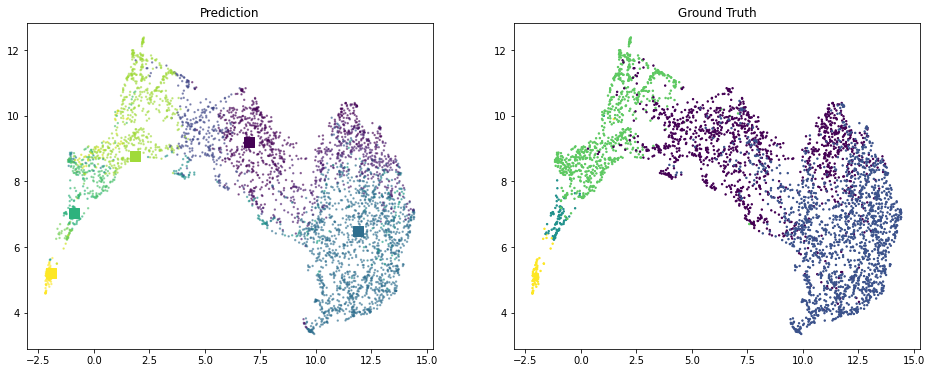

Start of epoch 1
16/16 [==============================] - 3s 196ms/step - loss_neg_E_nb: 715.9990 - loss_neg_E_pz: 20.8406 - loss_E_qzx   : -3.0210 - loss_total: 751.4476
 Training loss over epoch: 749.59326171875
 713.566650,  21.019341, -3.006029
Start of epoch 2
16/16 [==============================] - 3s 193ms/step - loss_neg_E_nb: 704.8328 - loss_neg_E_pz: 19.9336 - loss_E_qzx   : -3.0844 - loss_total: 747.3462
 Training loss over epoch: 747.369140625
 713.174194,  20.166954, -3.069580
Start of epoch 3
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 713.1374 - loss_neg_E_pz: 19.3216 - loss_E_qzx   : -3.1476 - loss_total: 746.3731
 Training loss over epoch: 745.4655151367188
 712.834473,  19.448351, -3.132818
Start of epoch 4
16/16 [==============================] - 3s 193ms/step - loss_neg_E_nb: 713.3342 - loss_neg_E_pz: 19.1183 - loss_E_qzx   : -3.2099 - loss_total: 746.0357
 Training loss over epoch: 745.1029052734375
 713.388123,  19.052696, -3.195344
St

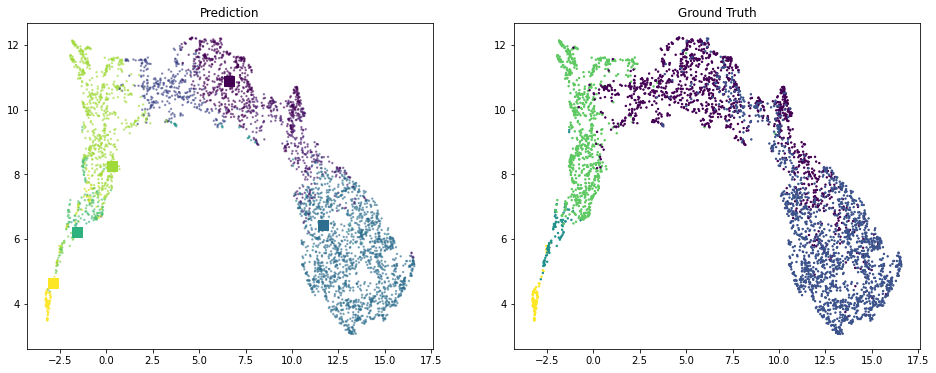

Start of epoch 16
16/16 [==============================] - 3s 197ms/step - loss_neg_E_nb: 698.9991 - loss_neg_E_pz: 15.9861 - loss_E_qzx   : -3.9127 - loss_total: 730.9207
 Training loss over epoch: 734.75634765625
 710.747437,  15.904339, -3.899879
Start of epoch 17
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 710.9018 - loss_neg_E_pz: 15.6950 - loss_E_qzx   : -3.9673 - loss_total: 732.3671
 Training loss over epoch: 733.7453002929688
 710.339050,  15.657618, -3.954458
Start of epoch 18
16/16 [==============================] - 3s 195ms/step - loss_neg_E_nb: 714.0458 - loss_neg_E_pz: 15.5436 - loss_E_qzx   : -4.0214 - loss_total: 732.5065
 Training loss over epoch: 733.428955078125
 710.326904,  15.559710, -4.008690
Start of epoch 19
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 724.8362 - loss_neg_E_pz: 15.4522 - loss_E_qzx   : -4.0753 - loss_total: 737.2866
 Training loss over epoch: 733.0350341796875
 710.296875,  15.431808, -4.06

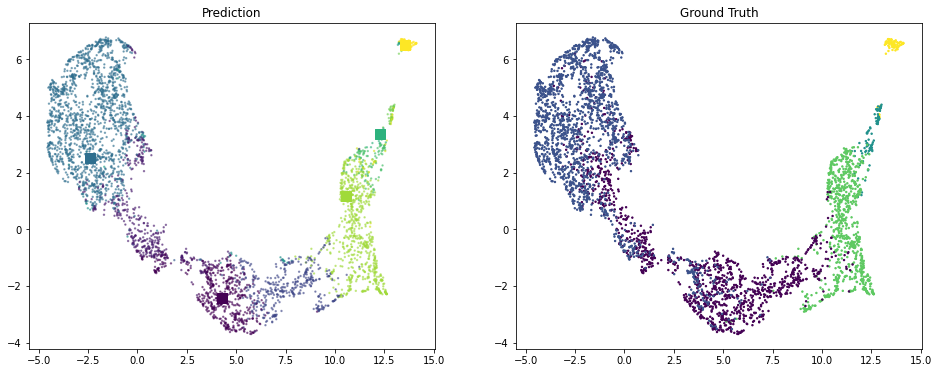

Start of epoch 31
16/16 [==============================] - 3s 195ms/step - loss_neg_E_nb: 697.6031 - loss_neg_E_pz: 14.1486 - loss_E_qzx   : -4.6878 - loss_total: 725.7871
 Training loss over epoch: 727.0079956054688
 707.873047,  14.243819, -4.676400
Start of epoch 32
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 725.6440 - loss_neg_E_pz: 14.0019 - loss_E_qzx   : -4.7357 - loss_total: 725.9451
 Training loss over epoch: 727.1118774414062
 708.348022,  14.106328, -4.724421
Start of epoch 33
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 706.5947 - loss_neg_E_pz: 13.9508 - loss_E_qzx   : -4.7827 - loss_total: 728.1153
 Training loss over epoch: 726.6184692382812
 708.049927,  14.056043, -4.771725
Start of epoch 34
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 716.4245 - loss_neg_E_pz: 13.9265 - loss_E_qzx   : -4.8300 - loss_total: 727.2168
 Training loss over epoch: 725.935791015625
 707.572571,  14.000629, -4.

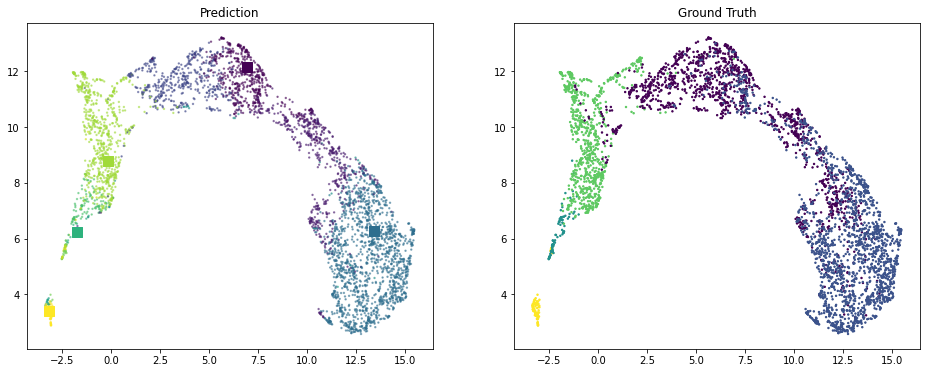

Start of epoch 46
16/16 [==============================] - 3s 196ms/step - loss_neg_E_nb: 686.3649 - loss_neg_E_pz: 13.3503 - loss_E_qzx   : -5.3582 - loss_total: 722.8321
 Training loss over epoch: 721.7471923828125
 705.630676,  13.406787, -5.348543
Start of epoch 47
16/16 [==============================] - 3s 193ms/step - loss_neg_E_nb: 708.1105 - loss_neg_E_pz: 13.1661 - loss_E_qzx   : -5.4007 - loss_total: 722.3933
 Training loss over epoch: 721.72314453125
 705.712585,  13.395992, -5.390749
Start of epoch 48
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 695.4614 - loss_neg_E_pz: 13.6452 - loss_E_qzx   : -5.4414 - loss_total: 722.1471
 Training loss over epoch: 722.046630859375
 706.156738,  13.377011, -5.432044
Start of epoch 49
16/16 [==============================] - 3s 193ms/step - loss_neg_E_nb: 695.3488 - loss_neg_E_pz: 13.3223 - loss_E_qzx   : -5.4804 - loss_total: 719.5481
 Training loss over epoch: 721.4082641601562
 705.635498,  13.357571, -5.47

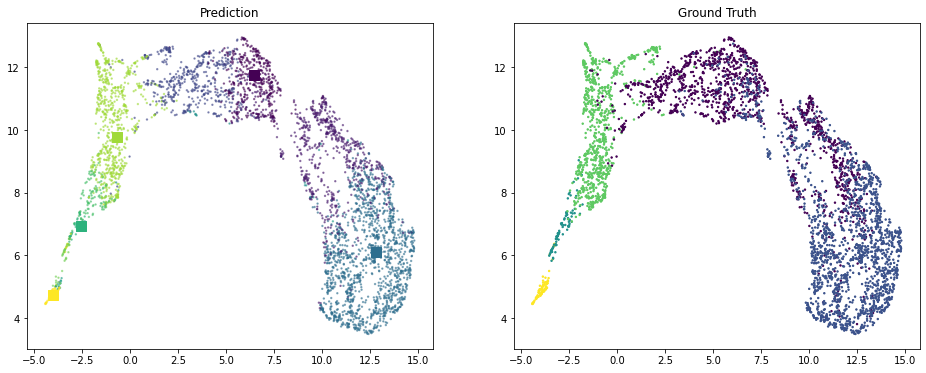

Start of epoch 61
16/16 [==============================] - 3s 196ms/step - loss_neg_E_nb: 700.1000 - loss_neg_E_pz: 13.1823 - loss_E_qzx   : -5.9207 - loss_total: 717.9901
 Training loss over epoch: 718.8621826171875
 704.482910,  13.102304, -5.912696
Start of epoch 62
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 703.7943 - loss_neg_E_pz: 13.1441 - loss_E_qzx   : -5.9541 - loss_total: 717.0581
 Training loss over epoch: 719.0037231445312
 704.660217,  13.118109, -5.946336
Start of epoch 63
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 730.3578 - loss_neg_E_pz: 13.0944 - loss_E_qzx   : -5.9866 - loss_total: 722.1262
 Training loss over epoch: 719.2426147460938
 705.030212,  13.085231, -5.979019
Start of epoch 64
16/16 [==============================] - 3s 195ms/step - loss_neg_E_nb: 700.8094 - loss_neg_E_pz: 12.9710 - loss_E_qzx   : -6.0196 - loss_total: 719.8405
 Training loss over epoch: 719.056884765625
 704.825562,  13.127424, -6.

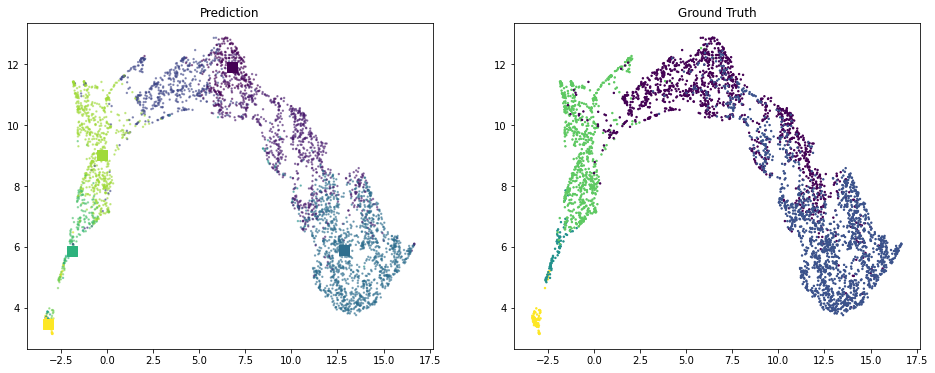

Start of epoch 76
16/16 [==============================] - 3s 195ms/step - loss_neg_E_nb: 703.0461 - loss_neg_E_pz: 13.0644 - loss_E_qzx   : -6.3723 - loss_total: 719.0178
 Training loss over epoch: 716.9112548828125
 703.642395,  13.000826, -6.366427
Start of epoch 77
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 709.3382 - loss_neg_E_pz: 12.9801 - loss_E_qzx   : -6.3980 - loss_total: 713.4791
 Training loss over epoch: 716.8771362304688
 703.639893,  13.010468, -6.391804
Start of epoch 78
16/16 [==============================] - 3s 193ms/step - loss_neg_E_nb: 725.3480 - loss_neg_E_pz: 13.0939 - loss_E_qzx   : -6.4241 - loss_total: 718.1763
 Training loss over epoch: 717.5922241210938
 704.416443,  13.006021, -6.418062
Start of epoch 79
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 719.9339 - loss_neg_E_pz: 12.8775 - loss_E_qzx   : -6.4502 - loss_total: 716.3741
 Training loss over epoch: 717.0247802734375
 703.867371,  13.022671, -6

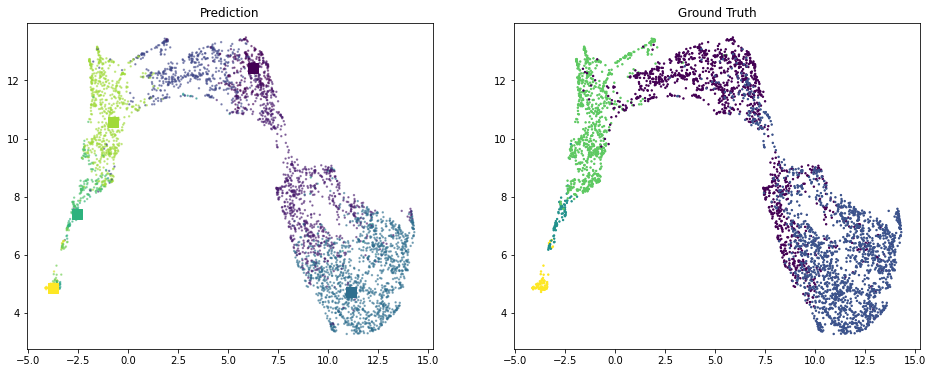

Start of epoch 91
16/16 [==============================] - 3s 196ms/step - loss_neg_E_nb: 708.7065 - loss_neg_E_pz: 13.0676 - loss_E_qzx   : -6.7210 - loss_total: 714.5161
 Training loss over epoch: 715.6640625
 703.170776,  12.963442, -6.716777
Start of epoch 92
16/16 [==============================] - 3s 195ms/step - loss_neg_E_nb: 697.5661 - loss_neg_E_pz: 12.9991 - loss_E_qzx   : -6.7396 - loss_total: 715.7612
 Training loss over epoch: 715.9771118164062
 703.342407,  13.052540, -6.735172
Start of epoch 93
16/16 [==============================] - 3s 196ms/step - loss_neg_E_nb: 713.1598 - loss_neg_E_pz: 12.9439 - loss_E_qzx   : -6.7594 - loss_total: 718.8528
 Training loss over epoch: 715.318359375
 702.831360,  12.998531, -6.755041
Start of epoch 94
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 707.7433 - loss_neg_E_pz: 13.0472 - loss_E_qzx   : -6.7753 - loss_total: 716.4918
 Training loss over epoch: 715.5498657226562
 703.123230,  12.985100, -6.771822
St

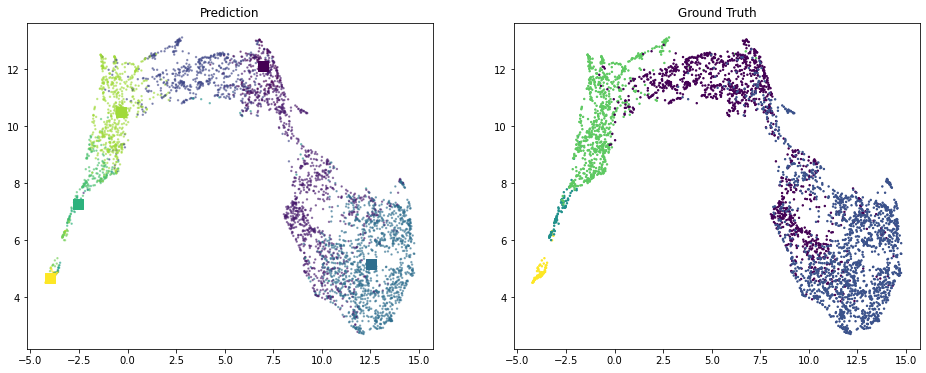

Start of epoch 106
16/16 [==============================] - 3s 197ms/step - loss_neg_E_nb: 694.6100 - loss_neg_E_pz: 13.2838 - loss_E_qzx   : -6.9765 - loss_total: 715.9933
 Training loss over epoch: 714.937744140625
 702.756958,  13.063560, -6.973201
Start of epoch 107
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 706.0466 - loss_neg_E_pz: 13.1037 - loss_E_qzx   : -6.9902 - loss_total: 713.4341
 Training loss over epoch: 715.0220947265625
 702.962585,  13.016658, -6.986878
Start of epoch 108
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 712.9756 - loss_neg_E_pz: 13.1197 - loss_E_qzx   : -7.0029 - loss_total: 713.8025
 Training loss over epoch: 714.7391967773438
 702.721985,  13.008469, -6.999898
Start of epoch 109
16/16 [==============================] - 3s 196ms/step - loss_neg_E_nb: 706.0910 - loss_neg_E_pz: 13.1103 - loss_E_qzx   : -7.0161 - loss_total: 714.1238
 Training loss over epoch: 715.0288696289062
 702.995667,  13.029800,

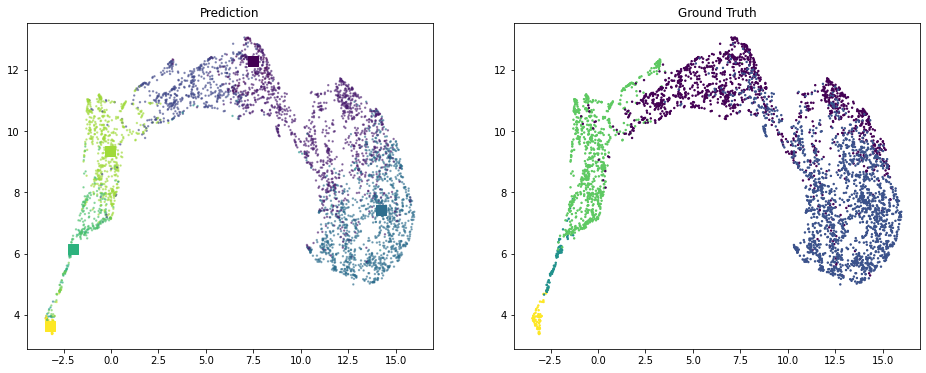

Start of epoch 121
16/16 [==============================] - 3s 196ms/step - loss_neg_E_nb: 710.4581 - loss_neg_E_pz: 13.1420 - loss_E_qzx   : -7.1604 - loss_total: 717.1960
 Training loss over epoch: 713.7539672851562
 701.921997,  13.073705, -7.157684
Start of epoch 122
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 712.9677 - loss_neg_E_pz: 13.0204 - loss_E_qzx   : -7.1713 - loss_total: 712.4057
 Training loss over epoch: 714.5972900390625
 702.944458,  12.995192, -7.168771
Start of epoch 123
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 703.6441 - loss_neg_E_pz: 12.9536 - loss_E_qzx   : -7.1798 - loss_total: 713.7581
 Training loss over epoch: 714.2205810546875
 702.507935,  13.034253, -7.177938
Start of epoch 124
16/16 [==============================] - 3s 194ms/step - loss_neg_E_nb: 706.5393 - loss_neg_E_pz: 12.8979 - loss_E_qzx   : -7.1889 - loss_total: 715.1711
Best Epoch: 114. Best Metric: 713.630127.
Early stopping.
Training D

In [10]:
model.train(learning_rate = 1e-3,        # (Optional) the initial learning rate for the Adam optimizer (the default is 1e-3).
            batch_size=256,              # (Optional) the batch size for pre-training (the default is 32). 
            L=1,                         # (Optional) the number of MC samples (the default is 1).
            num_epoch = 300,             # (Optional) the maximum number of epoches (the default is 300).                
            num_step_per_epoch = None,   # (Optional) the number of step per epoch, it will be inferred from number of cells and batch size if it is None (the default is None).
            early_stopping_tolerance=0.1,  # (Optional) the minimum change of loss to be considered as an improvement (the default is 1e-3).
            early_stopping_patience=10,   # (Optional) the maximum number of epoches if there is no improvement (the default is 10).
            early_stopping_warmup=0,     # (Optional) the number of warmup epoches (the default is 0).
            weight=2,
            plot_every_num_epoch=15,
            path_to_weights=None         # (Optional) the path of weight file to be saved; not saving weight if None (the default is None). 
            )

# Inference

## Trajectory and Pseudotime

In [11]:
# initialze inference
model.init_inference(batch_size=32, L=100) # L is the number of MC samples
# after initialization, we can access some variables by model.pc_x, model.w, model.w_tilde, etc..

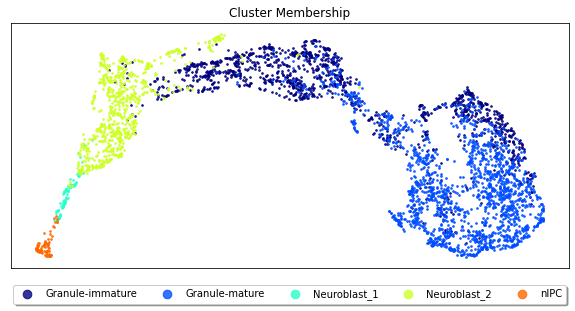

[[0.   0.42 0.   0.31 0.  ]
 [0.42 0.   0.   0.   0.  ]
 [0.   0.   0.   0.2  0.17]
 [0.31 0.   0.2  0.   0.  ]
 [0.   0.   0.17 0.   0.  ]]
[(0, 1), (0, 3), (2, 3), (2, 4)]


In [12]:
import networkx as nx
# compute inference score, and get umap embedding
# a plot of clustering result will be displayed
G = model.comp_inference_score(method='modified_map',  # 'mean', 'modified_mean', 'map', and 'modified_map'
                               thres=0.5,              # (Optional) threshold for compute the conditional probablity, only applies to 'mean' and 'modified_mean'
                               no_loop=True            # if no_loop=True, then find the maximum spanning tree
                               )           
# returned G is the score graph
print(np.round(nx.to_numpy_matrix(G), 2))
print(G.edges)

Now, the user needs to provide the initial node for the trajectory.

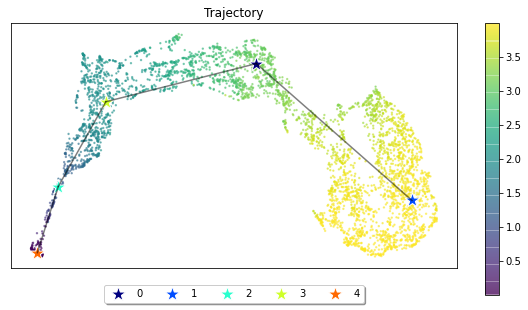

(<networkx.classes.graph.Graph at 0x7efe1413edd8>,
 array([[0.        , 0.        , 0.11766099, 0.        , 0.882339  ],
        [0.        , 0.        , 0.00958845, 0.        , 0.9904115 ],
        [0.        , 0.        , 0.04793189, 0.        , 0.9520681 ],
        ...,
        [0.03284105, 0.967159  , 0.        , 0.        , 0.        ],
        [0.06301299, 0.936987  , 0.        , 0.        , 0.        ],
        [0.1501572 , 0.8498428 , 0.        , 0.        , 0.        ]],
       dtype=float32),
 array([0.117661  , 0.00958848, 0.04793191, ..., 3.96715879, 3.93698692,
        3.84984303]))

In [17]:
# Here we identify the 'begin_node_pred' as the one having minimum average 
# distance with the cells in the true begin node.
begin_node_true = model.le.transform([data['root_milestone_id']])[0]
begin_node_pred = int(np.argmin(np.mean((
                        model.z[model.labels==begin_node_true,:,np.newaxis] - 
                        model.mu[np.newaxis,:,:])**2, axis=(0,1))))
model.infer_trajectory(init_node=begin_node_pred,  # initial node for computing pseudotime.
                       cutoff=None                 # (Optional) cutoff score for edges (the default is 0.01).
                       )  

## Marker Genes

In [18]:
model.gene_names

array(['Hdac5', 'Tpra1', 'Trim9', ..., 'Vstm5', 'Avpi1', 'Col3a1'],
      dtype='<U14')

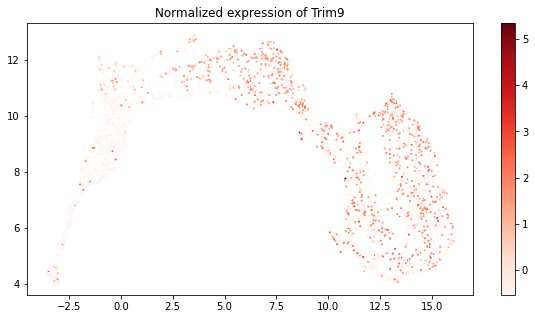

In [21]:
model.plot_marker_gene('Trim9')